In [251]:
import mlflow.pyfunc
from typing import Any, Dict, Union
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, root_mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import shap

Things to cover in the 2nd article: 
1. Pipeline
    * preprocessing that need to be trained
    * model pipeline with switchable preprocessor
    * model explanation & visualization
2. Algorithm agnostic
    * the pipeline should be able to easily switch between algorithms & preprocessing logics
    * some complexities might need to be built-in for some component of the pipeline (say explanation) to ensure uniform API

Steps

1. The minimalist algorithm agnostic pipeline (Done)
    * ~~static preprocessing~~
    * ~~accept any model~~
    * ~~demo different algorithms~~
2. Pipeline with custom preprocesser (Done)
    * ~~custom preprocesser 1 for numeric features~~
    * ~~demo the pipeline~~
    * ~~customer preprocesser 2 that can handle categorical features too~~
    * ~~demo using the same pipeline but calling the advanced preprocesser~~
3. Add explainer (Done)


# A Pre-Processor (V1)

### Create A Custome Preprocessor 

In [252]:
class PreProcessor(BaseEstimator, TransformerMixin):
    """
    A custom preprocessor that handles scaling and imputation of numeric features.

    Attributes:
        transformer (Pipeline): Pipeline for scaling and imputing numeric data.
        features (List[str]): List of feature names from the input DataFrame.
    """

    def __init__(self):
        """
        Initializes the PreProcessor with a placeholder for the transformer pipeline.
        """
        self.transformer = None

    def fit(self, X, y=None):
        """
        Fits the transformer on the provided dataset by configuring scaling and imputing on numeric features.

        Parameters:
            X (pd.DataFrame): The input features to fit the transformer.
            y (pd.Series, optional): Target variable, not used in this method.
        
        Returns:
            PreProcessor: The fitted transformer instance.
        """
        self.features = X.columns.tolist()

        if self.features:
            self.transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])
            self.transformer.fit(X[self.features])

        return self

    def transform(self, X):
        """
        Transforms the input data by applying the fitted scaling and imputing pipeline.

        Parameters:
            X (pd.DataFrame): The input features to transform.
        
        Returns:
            pd.DataFrame: The transformed data with scaled and imputed numeric features.
        """
        X_transformed = pd.DataFrame()

        if self.features:
            transformed_data = self.transformer.transform(X[self.features])
            X_transformed[self.features] = transformed_data

        X_transformed.index = X.index

        return X_transformed

    def fit_transform(self, X, y=None):
        """
        Fits the transformer on the input data and then transforms it.

        Parameters:
            X (pd.DataFrame): The input features to fit and transform.
            y (pd.Series, optional): Target variable, not used in this method.
        
        Returns:
            pd.DataFrame: The transformed data.
        """
        self.fit(X, y)
        return self.transform(X)


In [253]:
# Create a synthetic dataset
n_feature = 10
n_inform = 4 
n_redundant = 0
n_samples = 1000
X, y = make_classification(n_samples = n_samples, n_features = n_feature, 
                            n_informative = n_inform, n_redundant=n_redundant, shuffle=False, random_state=12)
informative_features_names = [f'inf_{i+1}' for i in range(n_inform)]
random_features_names = [f'rand_{i+n_inform+1}' for i in range(n_feature - n_inform)]
X = pd.DataFrame(X, columns = informative_features_names + random_features_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [254]:
# a quick look at the data using sweetviz
# import sweetviz as sv
# train_df = X_train.copy()
# train_df['target'] = y_train
# report = sv.analyze(train_df, target_feat='target')
# report.show_html("svreports/synthetic_df_eda.html")

In [255]:
# Test the preprocessor
preprocessor_v1 = PreProcessor() # define the preprocessor
X_train_transformed = preprocessor_v1.fit_transform(X_train)  # train the preprocessor on the train data
X_test_transformed = preprocessor_v1.transform(X_test) # apply the preprocessor on the new data

In [256]:
# sweetviz report on the preprocessed data for comparison and review
# train_df_transformed = X_train_transformed.copy()
# train_df_transformed['target'] = y_train
# report = sv.analyze(train_df_transformed, target_feat='target')
# report.show_html("svreports/synthetic_df_transformed_eda.html")

### Utilize the Preprocessor in the PL Pipeline

Now let's utilize the preprocessor in the ML pipeline. 

In [257]:
class ML_PIPELINE(mlflow.pyfunc.PythonModel):
    """
    ML_PIPELINE is a custom implementation of an MLflow Python model designed to work with 
    any scikit-learn compatible model (e.g., XGBoost, LightGBM). This class provides methods 
    for data preprocessing, model training, and making predictions, streamlining the process 
    of deploying machine learning models with MLflow.

    Attributes:
        model (BaseEstimator or None): A scikit-learn compatible model instance used for 
            making predictions, initialized as None if not provided at instantiation.
        preprocessor (Any or None): An optional preprocessing pipeline or transformer applied 
            to input data before model training or inference.
        config (Any or None): An optional configuration dictionary or object that can be used 
            to pass additional settings or hyperparameters for the model.
        task: "regression" or "classification" based on model attribute
    """

    def __init__(self, model: BaseEstimator = None, preprocessor = None, config: Any = None):
        """
        Initialize the ML_PIPELINE with an optional model, preprocessor, and configuration.

        Parameters:
            model (BaseEstimator, optional): A scikit-learn compatible model, such as LightGBM 
                or XGBoost, for training and predictions. Defaults to None.
            preprocessor (Any, optional): A transformer or pipeline used to preprocess the input 
                data. Defaults to None.
            config (Any, optional): Additional configuration settings for the model, if needed. 
                Defaults to None.
        """
        self.model = model
        self.preprocessor = preprocessor
        self.config = config
        self.task = "classification" if hasattr(self.model, "predict_proba") else "regression"

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        """
        Train the model using the provided training data, after applying preprocessing.

        Parameters:
            X_train (pd.DataFrame): A DataFrame containing feature columns for training.
            y_train (pd.Series): A Series containing the target variable values.
        """
        X_train_preprocessed = self.preprocessor.fit_transform(X_train.copy())
        self.model.fit(X_train_preprocessed, y_train)

    def predict(self, context: Any, model_input: pd.DataFrame) -> Any:
        """
        Make predictions using the pre-trained model, applying preprocessing to the input data.

        Parameters:
            context (Any): Optional context information provided by MLflow during the 
                prediction phase.
            model_input (pd.DataFrame): The DataFrame containing input features for predictions.

        Returns:
            Any: A NumPy array or DataFrame with the predicted probabilities or output values.
        """
        processed_model_input = self.preprocessor.transform(model_input.copy())
        if self.task == "classification":
            prediction = self.model.predict_proba(processed_model_input)[:,1]
        elif self.task == "regression":
            prediction = self.model.predict(processed_model_input)
        return prediction

In [258]:
# define the ML pipeline instance
ml_pipeline = ML_PIPELINE(model = lgb.LGBMClassifier(verbose = -1),
                        #   model = RandomForestClassifier(), # to switch to another algorithm
                          preprocessor = PreProcessor())

In [259]:
# train the ML pipeline then use it for prediction
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context=None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc: {auc:.3f}")

auc: 0.975


### Easily Migrate to a Different Preprocessor

The above preprocessor has some room for improvement. For one, it doesn't handle categorical features. Let's

* create a more sophisticated preprocessor with the same API
* test switching preprocessor  to the ML pipeline (we shouldn't need to change a single line in the ML Pipeline class)

In [260]:
class PreProcessor_v2(BaseEstimator, TransformerMixin):
    """
    A custom transformer that scales numeric data and encodes categorical features, 
    designed to be compatible with scikit-learn's transformation pipeline.

    Attributes:
        num_impute_strategy (str): The strategy for imputing missing values in numerical features, 
            defaults to 'median'.
        cat_impute_strategy (str): The strategy for imputing missing values in categorical features, 
            defaults to 'most_frequent'.
        num_transformer (Pipeline): A pipeline for numerical feature transformation, 
            which includes steps for imputation and scaling.
        cat_transformer (Pipeline): A pipeline for categorical feature transformation, 
            which includes steps for imputation and one-hot encoding.
        transformed_cat_cols (List[str]): List of column names generated from one-hot encoding 
            of categorical features, populated after fitting.
        num_features (List[str]): List of numerical feature names identified from the input data.
        cat_features (List[str]): List of categorical feature names identified from the input data.
    """

    def __init__(self,num_impute_strategy = 'median',cat_impute_strategy = 'most_frequent'):
        """
        Initializes the CustomTransformer with attributes to store the transformers for numeric and categorical data.
        """
        self.num_impute_strategy = num_impute_strategy
        self.cat_impute_strategy = cat_impute_strategy

    def fit(self, X, y=None):
        """
        Fits the transformer on the provided dataset, configuring scaling and encoding as necessary.

        Parameters:
            X (pd.DataFrame): Input features for fitting the transformer.
            y (pd.Series, optional): Target variable, not used in this method.
        
        Returns:
            CustomTransformer: The fitted transformer instance.
        """
        self.num_features = X.select_dtypes(include=np.number).columns.tolist()
        self.cat_features = X.select_dtypes(exclude=np.number).columns.tolist()

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.num_impute_strategy)),
                ('scaler', StandardScaler())
            ])
            self.num_transformer.fit(X[self.num_features])
        
        if self.cat_features:
            self.cat_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.cat_impute_strategy)),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ])
            self.cat_transformer.fit(X[self.cat_features])
        
        return self

    def get_transformed_cat_cols(self):
        """
        Generates a list of transformed categorical column names after one-hot encoding.

        Returns:
            List[str]: List of one-hot encoded categorical column names.
        """
        cat_cols = []
        cats = self.cat_features
        cat_values = self.cat_transformer['encoder'].categories_
        for cat, values in zip(cats, cat_values):
            cat_cols += [f'{cat}_{value}' for value in values]
        
        return cat_cols

    def transform(self, X):
        """
        Transforms the input data by applying scaling and encoding based on the fitted transformers.

        Parameters:
            X (pd.DataFrame): Input features to be transformed.
        
        Returns:
            pd.DataFrame: The transformed data.
        """
        X_transformed = pd.DataFrame()

        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            X_transformed[self.num_features] = transformed_num_data
        
        if self.cat_features:
            transformed_cat_data = self.cat_transformer.transform(X[self.cat_features]).toarray()
            self.transformed_cat_cols = self.get_transformed_cat_cols()
            transformed_cat_df = pd.DataFrame(transformed_cat_data, columns=self.transformed_cat_cols)
            X_transformed = pd.concat([X_transformed, transformed_cat_df], axis=1)
        
        X_transformed.index = X.index

        return X_transformed

    def fit_transform(self, X, y=None):
        """
        Fits the transformer and then applies the transformations to the input data.

        Parameters:
            X (pd.DataFrame): Input features for fitting and transforming.
            y (pd.Series, optional): Target variable, not used in this method.
        
        Returns:
            pd.DataFrame: The transformed data.
        """
        self.fit(X, y)
        return self.transform(X)

In [261]:
# change X['inf_1] to categorical
percentiles = [0, 0.1, 0.5, 0.9, 1]
labels = ['bottom', 'lower-mid', 'upper-mid', 'top']
X['inf_1'] = pd.qcut(X['inf_1'], q=percentiles, labels=labels)
# add missings
np.random.seed(42) 
missing_rate = 0.20 
n_missing = int(np.floor(missing_rate * X.size))
missing_indices = (np.random.randint(0, X.shape[0], n_missing), 
                   np.random.randint(0, X.shape[1], n_missing)) 
X.values[missing_indices] = np.nan
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [262]:
# the new preprocessor works fine as it handles categorical features well
preprocessor_v2 = PreProcessor_v2()
params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1 
}
model = xgb.XGBClassifier(**params)
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor = preprocessor_v2
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")

auc:0.970


In [263]:
# The default numeric impute strategy is median
ml_pipeline.preprocessor.num_impute_strategy

'median'

In [264]:
# we can adjust parameter of the preprocessor, let's change the impute strategy
preprocessor_v2 = PreProcessor_v2(num_impute_strategy = 'mean')
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor = preprocessor_v2
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")

auc:0.970


In [265]:
ml_pipeline.preprocessor.num_impute_strategy

'mean'

In [266]:
# As expected, the first preprocessor which doesn't handle categorical features will error with the new synthetic data
preprocessor = PreProcessor()
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor=preprocessor
)

try:
    ml_pipeline.fit(X_train, y_train)
except Exception as e:
    print(f"Error: {e}")

Error: Cannot use median strategy with non-numeric data:
could not convert string to float: 'lower-mid'


In [267]:
# of course, you can still switch between models
params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1 
}
model = xgb.XGBClassifier(**params)
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor=PreProcessor_v2()
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")


auc:0.970


# Explain the Model

Now the model pipeline contains a preprocessor to preprocess the data for the model. Let's add an explainer to explain the model. 

In [268]:
class ML_PIPELINE(mlflow.pyfunc.PythonModel):
    """
    ML_PIPELINE is a custom implementation of an MLflow Python model designed to work with 
    any scikit-learn compatible model (e.g., XGBoost, LightGBM). This class provides methods 
    for data preprocessing, model training, and making predictions, streamlining the process 
    of deploying machine learning models with MLflow.

    Attributes:
        model (BaseEstimator or None): A scikit-learn compatible model instance used for 
            making predictions, initialized as None if not provided at instantiation.
        preprocessor (Any or None): An optional preprocessing pipeline or transformer applied 
            to input data before model training or inference.
        config (Any or None): An optional configuration dictionary or object that can be used 
            to pass additional settings or hyperparameters for the model.
        task: "regression" or "classification" based on model attribute
    """

    def __init__(self, model: BaseEstimator = None, preprocessor = None, config: Any = None):
        """
        Initialize the ML_PIPELINE with an optional model, preprocessor, and configuration.

        Parameters:
            model (BaseEstimator, optional): A scikit-learn compatible model, such as LightGBM 
                or XGBoost, for training and predictions. Defaults to None.
            preprocessor (Any, optional): A transformer or pipeline used to preprocess the input 
                data. Defaults to None.
            config (Any, optional): Additional configuration settings for the model, if needed. 
                Defaults to None.
        """
        self.model = model
        self.preprocessor = preprocessor
        self.config = config
        self.task = "classification" if hasattr(self.model, "predict_proba") else "regression"

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        """
        Train the model using the provided training data, after applying preprocessing.

        Parameters:
            X_train (pd.DataFrame): A DataFrame containing feature columns for training.
            y_train (pd.Series): A Series containing the target variable values.
        """
        X_train_preprocessed = self.preprocessor.fit_transform(X_train.copy())
        self.model.fit(X_train_preprocessed, y_train)

    def predict(self, context: Any, model_input: pd.DataFrame) -> Any:
        """
        Make predictions using the pre-trained model, applying preprocessing to the input data.

        Parameters:
            context (Any): Optional context information provided by MLflow during the 
                prediction phase.
            model_input (pd.DataFrame): The DataFrame containing input features for predictions.

        Returns:
            Any: A NumPy array or DataFrame with the predicted probabilities or output values.
        """
        processed_model_input = self.preprocessor.transform(model_input.copy())
        if self.task == "classification":
            prediction = self.model.predict_proba(processed_model_input)[:,1]
        elif self.task == "regression":
            prediction = self.model.predict(processed_model_input)
        return prediction
    
    def explain_model(self,X):
        X_transformed = self.preprocessor.transform(X.copy())
        self.X_explain = X_transformed.copy()
        # get pre-transformed values for numeric features
        self.X_explain[self.preprocessor.num_features] = X[self.preprocessor.num_features]
        self.X_explain.reset_index(drop=True)
        try:
            # Attempt to create an explainer that directly supports the model
            explainer = shap.Explainer(self.model)
        except:
            # Fallback for models or shap versions where direct support may be limited
            explainer = shap.Explainer(self.model.predict, X_transformed)
        self.shap_values = explainer(X_transformed)  

        # get the shape of shap values and extract accordingly
        self.both_class = len(self.shap_values.values.shape) == 3
        if self.both_class:
            shap.summary_plot(self.shap_values[:,:,1])
        elif self.both_class == False:
            shap.summary_plot(self.shap_values)
    
    def explain_case(self,n):
        if self.shap_values is None:
            print("pls explain model first")
        else:
            self.shap_values.data = self.X_explain
            if self.both_class:
                shap.plots.waterfall(self.shap_values[:,:,1][n-1])
            elif self.both_class == False:
                shap.plots.waterfall(self.shap_values[n-1])

## Test for Classification Problem

In [269]:
# Train the new model pipeline with the explainer ability
ml_pipeline = ML_PIPELINE(
    # model = lgb.LGBMClassifier(verbose=-1),
    # model = RandomForestClassifier(),
    model = xgb.XGBClassifier(),
    preprocessor=PreProcessor_v2()
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")

auc:0.962


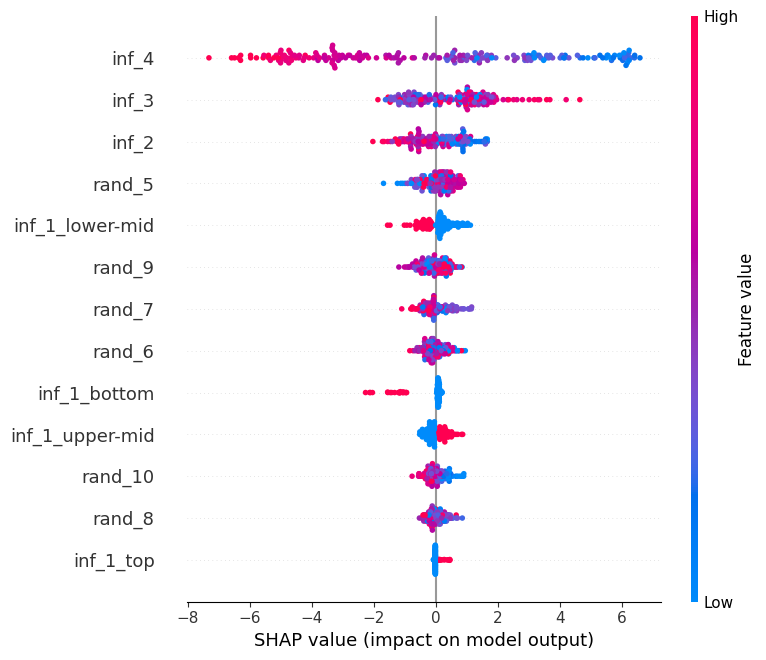

In [270]:
ml_pipeline.explain_model(X_test)

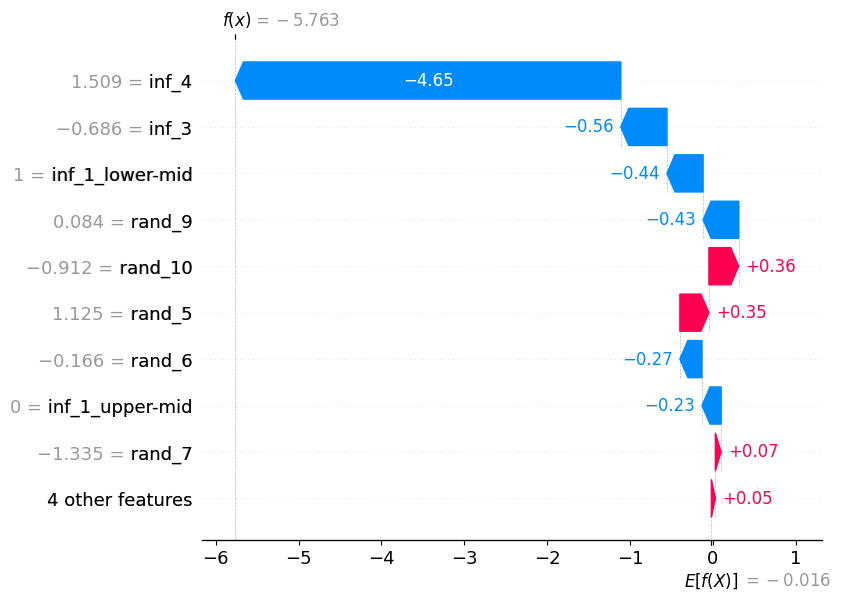

In [271]:
case_number = 2
ml_pipeline.explain_case(case_number)

## Test for Regression Problem

In [280]:
# Create a synthetic dataset for regression problem
n_feature = 10
n_inform = 4 
n_samples = 1000
X, y = make_regression(n_samples = n_samples, n_features = n_feature, 
                            n_informative = n_inform, shuffle=False, random_state=12)
informative_features_names = [f'inf_{i+1}' for i in range(n_inform)]
random_features_names = [f'rand_{i+n_inform+1}' for i in range(n_feature - n_inform)]
X = pd.DataFrame(X, columns = informative_features_names + random_features_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Switch to a regression algorithm
ml_pipeline = ML_PIPELINE(
    model = lgb.LGBMRegressor(verbose=-1),
    # model = RandomForestRegressor(),
    # model = xgb.XGBRegressor(),
    preprocessor=PreProcessor_v2()
)
ml_pipeline.fit(X_train, y_train)
y_pred = ml_pipeline.predict(context=None, model_input=X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"rmse:{rmse:.2f}")

rmse:26.09


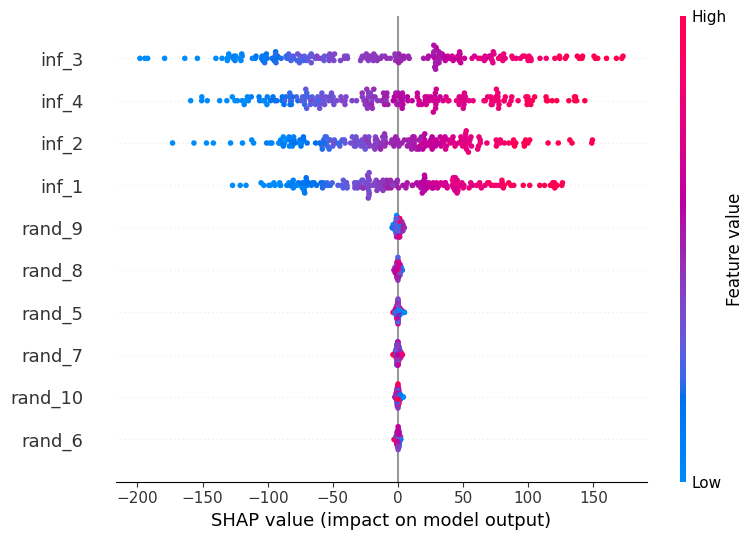

In [281]:
ml_pipeline.explain_model(X_test)

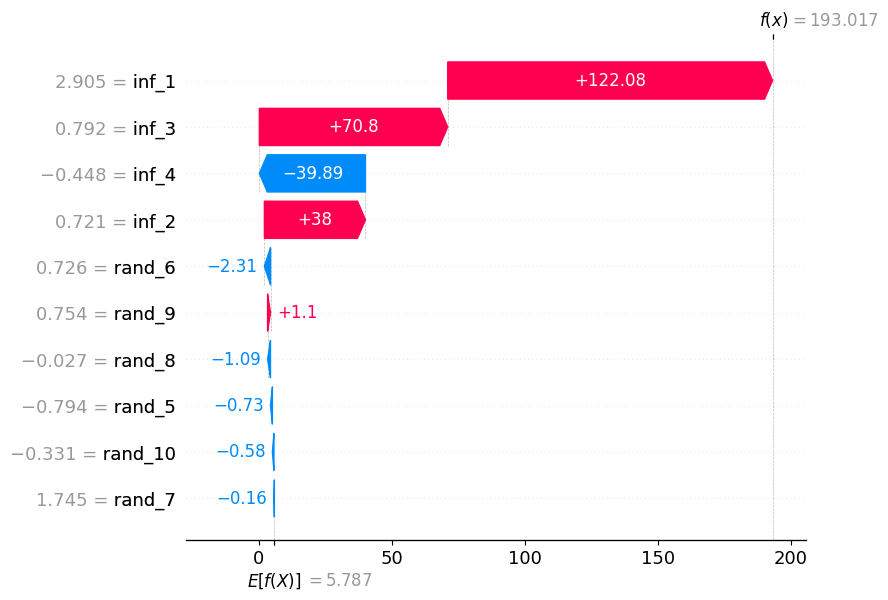

In [282]:
case_number = 5
ml_pipeline.explain_case(case_number)